In [1]:
import numpy as np
import librosa
from scipy.io import wavfile
from aubio import onset
from scipy.signal import butter, lfilter
import matplotlib.pyplot as plt

from read_labels import read_labels

%matplotlib inline

In [2]:
def split_chunks(x):
    chunks = []
    previous = None
    for sample in x:
        if sample != previous:
            chunks.append([])
        chunks[-1].append(sample)
        previous = sample
    return chunks

def join_chunks(chunks):
    return [item for sublist in chunks for item in sublist]

def replace_small_chunks(chunks, search, substitute, min_length):
    modified = []
    for chunk in chunks:
        cur = chunk[0]
        if cur == search and len(chunk) < min_length:
            cur = substitute
        modified.append([cur for x in chunk])
    return split_chunks(join_chunks(modified))

# do a grid search to determine the min and max chunk sizes
# that minimize standard deviation of chunk lengths
def get_optimal_chunks(chunks, min_length=3, max_length=500, n=10):
    best_std = None
    best_chunks = []
    for quiet_thresh in np.linspace(min_length, max_length, n):
        for sound_thresh in np.linspace(min_length, max_length, n):
            cur = replace_small_chunks(chunks, False, True, quiet_thresh)
            cur = replace_small_chunks(cur, True, False, sound_thresh)
            chunk_lengths = [len(chunk) for chunk in cur]
            cur_std = np.std(chunk_lengths)
            if (best_std is None or cur_std < best_std) and len(cur) > 1:
#                 print cur_std, 'better than', best_std, 'using', quiet_thresh, sound_thresh
                best_chunks = cur
                best_std = cur_std
    return best_chunks

In [3]:
filename = '/home/tracek/Data/Birdman/raw/STHELENA-02_20140605_200000_1_16k.wav'
sheets = read_labels('/home/tracek/Data/StHelena/sthelena_labels.xls')
sheet_selected = sheets['STHELENA-02_20140605_200000_1']

# in seconds [s]
sample_start_s = 0
sample_end_s = 90
min_duration_s = 0.050
max_duration_s = 0.750
threshold_amp = 0.1

win_s = 512 # samples
hop_s = win_s // 4

highpass_cut = 1000 # Hz

In [4]:
sr, signal = wavfile.read(filename)
signal = signal.astype('float32')

In [5]:
def butter_highpass(highcut, fs, order=12):
    nyq = 0.5 * fs
    high = highcut / nyq
    b, a = butter(order, high, btype='highpass')
    return b, a

b, a = butter_highpass(highpass_cut, sr, order=12)

In [6]:
condition = (sheet_selected['Time Start'] > sample_start_s) & (sheet_selected['Time End'] < sample_end_s)
sheet_sample = sheet_selected[condition]
sample = signal[int(sample_start_s * sr): int(sample_end_s * sr)]

sample = lfilter(b, a, sample).astype('float32')

windowed_sample = np.array_split(sample, np.arange(hop_s, len(sample), hop_s))

In [7]:
min_duration_frames = librosa.core.time_to_frames([min_duration_s], sr=sr, hop_length=hop_s)[0]
max_duration_frames = librosa.core.time_to_frames([max_duration_s], sr=sr, hop_length=hop_s)[0]

In [8]:
sample /= sample.max()
S = librosa.stft(sample, n_fft=win_s, hop_length=hop_s)
e = librosa.feature.rmse(S=S)[0]
e -= e.min()
e /= e.max()
et = np.where(e < threshold_amp, False, True)
chunks = split_chunks(et)
chunks = get_optimal_chunks(chunks, min_duration_frames, max_duration_frames, 10)
et = join_chunks(chunks)

In [9]:
slices = []
cur_slice = 0
for chunk in chunks:
    next_slice = cur_slice + len(chunk)
    if chunk[0] and len(chunk) < max_duration_frames:
        slices.append([cur_slice, next_slice])
    cur_slice = next_slice
    
slices_s = librosa.core.frames_to_time(slices, sr=sr, hop_length=hop_s)

In [10]:
slices_s

array([[  3.032,   3.104],
       [  3.272,   3.552],
       [  3.6  ,   3.728],
       [  3.816,   3.912],
       [ 10.056,  10.144],
       [ 10.36 ,  10.408],
       [ 10.48 ,  10.672],
       [ 10.744,  10.88 ],
       [ 10.944,  11.072],
       [ 11.144,  11.272],
       [ 20.416,  20.472],
       [ 65.024,  65.152],
       [ 65.344,  65.552],
       [ 65.624,  65.776],
       [ 65.848,  65.976],
       [ 66.096,  66.144],
       [ 80.976,  81.024],
       [ 81.336,  81.456],
       [ 81.56 ,  81.664],
       [ 81.776,  81.88 ],
       [ 81.96 ,  82.088],
       [ 82.216,  82.32 ],
       [ 86.328,  86.472],
       [ 86.648,  86.872],
       [ 86.936,  87.08 ],
       [ 87.168,  87.296],
       [ 87.424,  87.52 ],
       [ 88.616,  88.672],
       [ 88.912,  89.12 ],
       [ 89.176,  89.304],
       [ 89.36 ,  89.496],
       [ 89.56 ,  89.688],
       [ 89.776,  89.912]])

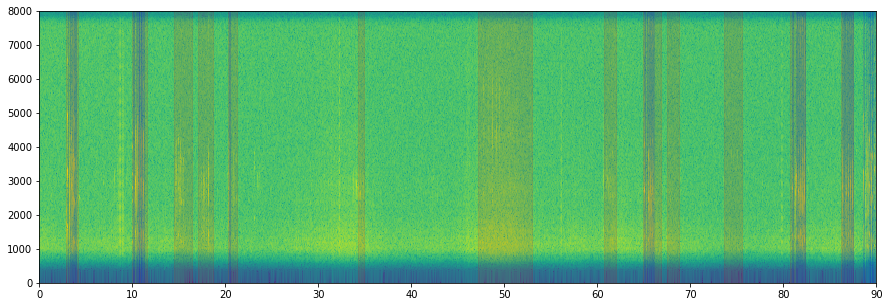

In [11]:
x_spacing = np.linspace(sample_start_s, sample_end_s, len(sample))
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
for index, row in sheet_sample.iterrows():
    if row['Species'] == 'Storm Petrel':
        ax.axvspan(xmin=row['Time Start'], xmax=row['Time End'], color='red', alpha=0.1)
for start, end in slices_s:
    ax.axvspan(xmin=start + sample_start_s, xmax=end + sample_start_s, color='blue', alpha=0.1)
spec = plt.specgram(sample, Fs=sr, NFFT=win_s, noverlap=hop_s, xextent=(sample_start_s, sample_end_s))

In [12]:
sheet_sample

,Date,File Name,Type of Call,Time Start,Time End,Species,Notes
0,2014-06-05,STHELENA-02_20140605_200000_1,Flight Call,2.905,4.197,Storm Petrel,NaN
1,2014-06-05,STHELENA-02_20140605_200000_1,Flight Call,10.008,11.622,Storm Petrel,NaN
2,2014-06-05,STHELENA-02_20140605_200000_1,Flight Call,14.527,16.464,Storm Petrel,NaN
3,2014-06-05,STHELENA-02_20140605_200000_1,Flight Call,17.110,18.724,Storm Petrel,NaN
4,2014-06-05,STHELENA-02_20140605_200000_1,Flight Call,20.338,21.307,Storm Petrel,NaN
5,2014-06-05,STHELENA-02_20140605_200000_1,Flight Call,34.220,34.866,Storm Petrel,NaN
6,2014-06-05,STHELENA-02_20140605_200000_1,Flight Call,47.134,52.944,Storm Petrel,NaN
7,2014-06-05,STHELENA-02_20140605_200000_1,Flight Call,60.692,61.984,Storm Petrel,NaN
8,2014-06-05,STHELENA-02_20140605_200000_1,Flight Call,64.889,66.826,Storm Petrel,NaN
9,2014-06-05,STHELENA-02_20140605_200000_1,Flight Call,67.472,68.763,Storm Petrel,NaN


In [13]:
sample_start_s + 27

27